# Environment Setup

In [44]:
# Enable autoreload of libraries on execution
%load_ext autoreload
%autoreload 2

%load_ext tensorboard

In [45]:
from IPython import get_ipython

def is_using_colab() -> bool:
    return "google.colab" in str(get_ipython())

In [46]:
if is_using_colab():
  !pip -q install torchinfo
  !pip -q install pytorch-lightning
  import zipfile
  from google.colab import drive
  import os

  !mkdir Experiments
  !mkdir Datasets
  
  # Copy code and datasets zips
  drive.mount('/content/drive')
  !cp -r "/content/drive/MyDrive/Master Thesis/02 - Code/." "."
  # !cp -r "/content/drive/MyDrive/Master Thesis/01 - Datasets/." "Datasets/."
  !cp -r "/content/drive/MyDrive/Master Thesis/01 - Datasets/DIV2K_800_5.zip" "Datasets/DIV2K_800_5.zip"

  # Extract datasets zips
  for zip in os.listdir("Datasets"):
    with zipfile.ZipFile(os.path.join("Datasets", zip), 'r') as zip_ref:
      zip_ref.extractall(os.path.join("Datasets", zip.replace(".zip", "")))
    os.remove(os.path.join("Datasets", zip))

  device = "cuda"
  experiments_dir = "Experiments"
  datasets_path = r"Datasets/"
else:
  device = "cuda"
  experiments_dir = "../05 - Experiments"
  datasets_path = r"C:\datasets"

In [48]:
import os
import time
import gc
import json

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display

from media_utils import plot_img

# Dataset Exploration


In [49]:
# dataset_path = r"G:\VM\Shared Folder\bags\0001.bag"
# EVENTS_TOPIC = "/cam0/events"
# IMAGES_TOPIC = "/cam0/image_raw"

dataset_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_jenga_destroy.bag"
EVENTS_TOPIC = "/dvs/events"
IMAGES_TOPIC = "/dvs/image_color"

## Dataset Inspection


### Inspect messages content


In [50]:
from dataset_utils import inspect_dataset
inspect_dataset(dataset_path)

/dvs/events
header: 
  seq: 3504
  stamp: 
    secs: 1553514337
    nsecs:  11357266
  frame_id: ''
height: 260
width: 346
events: 
  - 
    x: 123
    y: 250
    ts: 
      secs: 1553514336
      nsecs: 99136226...

/dvs/image_color
header: 
  seq: 0
  stamp: 
    secs: 1553514337
    nsecs:   3034266
  frame_id: ''
height: 260
width: 346
encoding: "bgr8"
is_bigendian: 0
step: 1038
data: [0, 84, 84, 0, 84, 84, 0, 84, 88, 0, 79, 8...

/dvs/image_raw
header: 
  seq: 4672
  stamp: 
    secs: 1553514337
    nsecs:   3034266
  frame_id: ''
height: 260
width: 346
encoding: "mono8"
is_bigendian: 0
step: 346
data: [18, 19, 24, 19, 27, 23, 28, 20, 27, 22...



##### **Image events content:**

**data**: binary image data encoded according to encoding

**encoding**: format used to encode the image data - e.g. mono8, bgr8

**width**, **height**: size of the image

**is_bigendian**: endianness of image

**step**: full row length in bytes

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Event events content:**

**events**: array of events

**width**, **height**: size of the camera sensor

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Events format:**

**x**, **y**: coordinates of the pixel sensor

**polarity**: polarity of the event in {True, False}

**ts**:

-   **secs**: seconds since epoch
-   **nsecs**: nanoseconds since ts.secs


### Inspect message timestamps


In [51]:
from dataset_utils import inspect_message_timestamps
inspect_message_timestamps(dataset_path, events_topic=EVENTS_TOPIC, images_topic=IMAGES_TOPIC)


     Topic Name          Event Timestamp
  0) /dvs/image_color    1553514337.0030344
  1) /dvs/events         1553514337.0113573
                         First event timestamp 1553514336.9913623 Last event timestamp 1553514337.0213542
  2) /dvs/image_color    1553514337.0280342
  3) /dvs/events         1553514337.0413592
                         First event timestamp 1553514337.0213573 Last event timestamp 1553514337.0513504
  4) /dvs/image_color    1553514337.0530353
  5) /dvs/events         1553514337.0713603
                         First event timestamp 1553514337.0513632 Last event timestamp 1553514337.0813544
  6) /dvs/image_color    1553514337.0780354
  7) /dvs/image_color    1553514337.1030352
  8) /dvs/events         1553514337.1113732
                         First event timestamp 1553514337.0813613 Last event timestamp 1553514337.1213531
  9) /dvs/image_color    1553514337.1280353
 10) /dvs/events         1553514337.1413844
                         First event timestamp 1553

The events are not completely sequential, since there can be two image events after each other (e.g. 6-7) but the first event timestamp of the next event is before the last image (e.g 8).

Moreover, there are some events that are acquired after the last image has been captured.


## Dataset Analysis

### Dataset Loading

In [52]:
from dataset_utils import load_bag_as_dataframes
events_df, images_df = load_bag_as_dataframes(dataset_path, events_topic=EVENTS_TOPIC, images_topic=IMAGES_TOPIC, max_events=1e6)
print("Events dataframe")
display(events_df)
print("Images dataframe")
display(images_df)


 43%|████▎     | 426/980 [00:06<00:08, 67.38it/s] 


Events dataframe


,seq,x,y,secs,polarity
0,3504,123,250,1.553514e+09,True
1,3504,195,70,1.553514e+09,True
2,3504,231,92,1.553514e+09,False
3,3504,171,197,1.553514e+09,False
4,3504,181,179,1.553514e+09,False
...,...,...,...,...,...
999995,3620,160,169,1.553514e+09,False
999996,3620,327,0,1.553514e+09,False
999997,3620,236,138,1.553514e+09,False
999998,3620,135,210,1.553514e+09,False


Images dataframe


,seq,secs,width,height,is_bigendian,encoding,step,data
0,0,1.553514e+09,346,260,0,bgr8,1038,"[0, 84, 84, 0, 84, 84, 0, 84, 88, 0, 79, 89, 0..."
1,1,1.553514e+09,346,260,0,bgr8,1038,"[0, 77, 84, 0, 77, 84, 0, 81, 88, 0, 81, 89, 0..."
2,2,1.553514e+09,346,260,0,bgr8,1038,"[0, 81, 84, 0, 81, 84, 0, 81, 88, 0, 81, 89, 0..."
3,3,1.553514e+09,346,260,0,bgr8,1038,"[0, 77, 84, 0, 77, 84, 0, 86, 88, 0, 86, 89, 0..."
4,4,1.553514e+09,346,260,0,bgr8,1038,"[0, 82, 84, 0, 82, 84, 0, 82, 86, 0, 81, 88, 0..."
...,...,...,...,...,...,...,...,...
150,150,1.553514e+09,346,260,0,bgr8,1038,"[0, 79, 84, 0, 79, 84, 0, 84, 88, 0, 88, 89, 0..."
151,151,1.553514e+09,346,260,0,bgr8,1038,"[0, 82, 86, 0, 82, 86, 0, 82, 89, 0, 84, 91, 0..."
152,152,1.553514e+09,346,260,0,bgr8,1038,"[0, 77, 84, 0, 77, 84, 0, 84, 86, 0, 86, 88, 0..."
153,153,1.553514e+09,346,260,0,bgr8,1038,"[0, 84, 86, 0, 84, 86, 0, 84, 89, 0, 82, 89, 0..."


Events and frames are already ordered by timestamp, since they are produced from a real simulation.


### Number of events per image frame

Check how many events there are among each image frame.

This roughly reflects the amount of movement in the sequence.


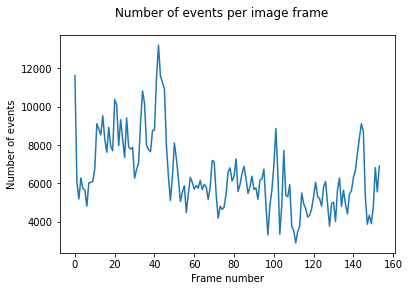

In [53]:
from dataset_utils import plot_number_of_events_per_frame
plot_number_of_events_per_frame(events_df, images_df)

### Check image frames frequency


Average milliseconds: 25.0000, Average fps: 40.00


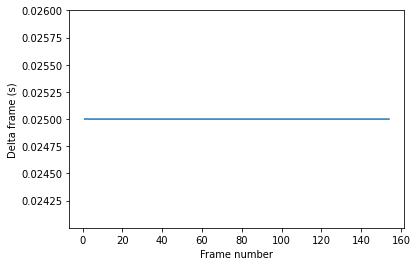

In [54]:
from dataset_utils import plot_image_frames_frequency
plot_image_frames_frequency(images_df)

### Save events for visualization


In [ ]:
from media_utils import save_visual_bayer_events, save_visual_accumulated_events

w, h = images_df.iloc[0].width, images_df.iloc[0].height
folder_name = os.path.basename(dataset_path).replace(".bag", "")
output_dir = os.path.join(os.path.dirname(dataset_path), folder_name)
save_visual_bayer_events(events_df, w, h, os.path.join(output_dir, "visual_events"))
save_visual_accumulated_events(events_df, w, h, os.path.join(output_dir, "visual_images"))

## Dataset Generation


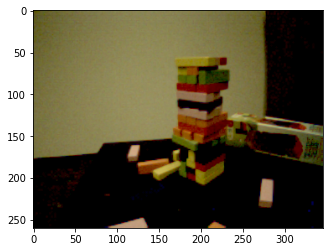

(10, 260, 346)


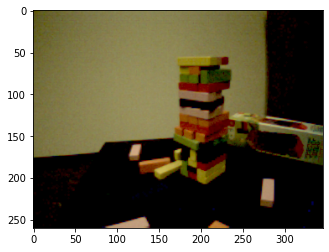

In [58]:
from dataset_utils import dataset_generator_from_batches
batches_path = os.path.join(dataset_path.replace(".bag", ""), "batches")
for batch in dataset_generator_from_batches(batches_path):

    # Old batch format
    (in_, events), out_ = batch
    plot_img(in_)
    print(events.shape)
    plot_img(out_)

    # New batch format
    # events, img = batch
    # print(events.shape)
    # plot_img(img)
    
    break


# Datasets Definition


In [21]:
DATASET_PARAMS = {
    "limit": None,
    "preload_to_RAM": False,
    "crop_size": (128, 128)
}

DATALOADER_PARAMS = {
    "batch_size": 24,
    "num_workers": 4,
    "pin_memory": True,
}

if is_using_colab():
    DATASET_PARAMS["preload_to_RAM"] = True
    DATALOADER_PARAMS["batch_size"] = 64
    DATALOADER_PARAMS["num_workers"] = 0

## CED Dataset

In [22]:
CED_DATASET_PATH = os.path.join(datasets_path, "CEDDataset")
available_sequences = os.listdir(CED_DATASET_PATH)
print("Available sequences:")
for i, seq in enumerate(available_sequences):
    print(f"{i:<5}{seq}")

Available sequences:
0    driving_city_4
1    simple_carpet
2    simple_color_keyboard_1
3    simple_color_keyboard_2
4    simple_fruit
5    simple_jenga_1
6    simple_jenga_destroy
7    simple_objects
8    simple_rabbits
9    simple_wires_1
10   simple_wires_2


In [23]:
from dataset import CEDDataset
train_datasets_names = ["simple_color_keyboard_1", "simple_fruit"]
train_dataset = CEDDataset(CED_DATASET_PATH, sequences=train_datasets_names, ignore_input_image=True, **DATASET_PARAMS)

valid_datasets_names = ["simple_rabbits"]
valid_dataset = CEDDataset(CED_DATASET_PATH, sequences=valid_datasets_names, ignore_input_image=True, **DATASET_PARAMS)

test_datasets_names = ["simple_color_keyboard_2", "simple_jenga_1", "simple_wires_1"]
test_dataset = CEDDataset(CED_DATASET_PATH, sequences=test_datasets_names, ignore_input_image=True, **DATASET_PARAMS)


## Synthetic Dataset from DIV2K

In [7]:
from dataset import DIV2KDataset
DIV2K_DATASET_PATH = os.path.join(datasets_path, "DIV2K_800_5")
# train_datasets_names = ["{:04}".format(i) for i in range(1, 790 + 1)]
train_datasets_names = ["{:04}".format(i) for i in range(1, 5 + 1)]
train_dataset = DIV2KDataset(DIV2K_DATASET_PATH, sequences=train_datasets_names, **DATASET_PARAMS)

valid_datasets_names = ["{:04}".format(i) for i in range(791, 795 + 1)]
valid_dataset = DIV2KDataset(DIV2K_DATASET_PATH, sequences=valid_datasets_names, **DATASET_PARAMS)

test_datasets_names = ["{:04}".format(i) for i in range(796, 800 + 1)]
test_dataset = DIV2KDataset(DIV2K_DATASET_PATH, sequences=test_datasets_names, **DATASET_PARAMS)


# PyTorch Dataset and DataLoader

In [24]:
# Check if there is no instersection between train, valid and test dataset
union = set(train_datasets_names).union(set(valid_datasets_names)).union(set(test_datasets_names)) 
sum_of_lengths = sum([len(ds) for ds in [train_datasets_names, valid_datasets_names, test_datasets_names]])
assert len(union) == sum_of_lengths, "Some datasets are in common"

In [25]:
from dataset import CEDDataset, ConcatBatchSampler

# Do not batch events coming from different datasets
# samplers = [torch.utils.data.RandomSampler(ds) for ds in train_datasets]
# sampler = ConcatBatchSampler(samplers=samplers, batch_size=TRAIN_DS_PARAMS["batch_size"], drop_last=False)
# train_dataloader = torch.utils.data.DataLoader(
#     concat_ds, batch_sampler=sampler,
# )

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, **DATALOADER_PARAMS)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, **DATALOADER_PARAMS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, **DATALOADER_PARAMS)

DATASET_PARAMS.update({
    "train_datasets_names": train_datasets_names, 
    "valid_datasets_names": valid_datasets_names, 
    "test_datasets_names": test_datasets_names
})

print("Train samples: {} \t Train batches: {:<10}".format(len(train_dataset), len(train_dataloader)))
print("Valid samples: {} \t Valid batches: {:<10}".format(len(valid_dataset), len(valid_dataloader)))
print("Test samples: {} \t Test batches: {:<10}".format(len(test_dataset), len(test_dataloader)))

Train samples: 25 	 Train batches: 2         
Valid samples: 25 	 Valid batches: 2         
Test samples: 25 	 Test batches: 2         


# Inspect datasets

In [59]:
# Inspect train dataloader
from media_utils import save_video_tensors
frames = []

# Old dataset format
# for (i, e), o in tqdm(train_dataloader):

for e, o in tqdm(train_dataloader):
  for batch in o:
    frames.append(batch)

save_video_tensors("train_frames.mp4", frames, 5)

100%|██████████| 48/48 [00:18<00:00,  2.56it/s]


In [12]:
# Inspect valid dataloader
from media_utils import save_video_tensors
frames = []

# Old dataset format
# for (i, e), o in tqdm(valid_dataloader):

for e, o in tqdm(valid_dataloader):
  for batch in o:
    frames.append(batch)

save_video_tensors("valid_frames.mp4", frames, 5)

100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


In [13]:
# Inspect test dataloader
from media_utils import save_video_tensors
frames = []

# Old dataset format
# for (i, e), o in tqdm(test_dataloader):

for e, o in tqdm(test_dataloader):
  for batch in o:
    frames.append(batch)

save_video_tensors("test_frames.mp4", frames, 5)

100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


# UNet AutoEncoder Model


In [ ]:
from torchinfo import summary
from models import EventsToImagesUNet

PARAMS = {
    "input_channels": 3 + 10,
}

model = EventsToImagesUNet(PARAMS["input_channels"])
# summary(model, input_size=(4, input_channels, 256, 336), device=device)


## Model Training


In [ ]:
from train import train_unet

PARAMS.update({
    "n_epochs": 3,
    "learning_rate": 0.0001,
    "comment": "",
})
PARAMS.update({"train_dataset_params": DATASET_PARAMS})

train_unet(model, device, train_dataloader, PARAMS, log_path=experiments_dir, valid_ds=valid_dataloader, save_best_model=True)

In [ ]:
torch.save(model.state_dict(), "model_thesis.pt")

In [ ]:
# Save input frames as video
from media_utils import save_video_tensors
imgs = []
for batch in tqdm(train_dataloader):
    (input_images, events_tensors), ground_truth_images = batch
    imgs += input_images
save_video_tensors("input_video.mp4", imgs, 30)


In [ ]:
# Save generated frames as video
use_prev_images_as_input = False

imgs = []
for i, batch in enumerate(tqdm(train_dataloader)):
    if use_prev_images_as_input and i != 0:
        input_images = generated_images
    else:
        (input_images, events_tensors), ground_truth_images = batch
    input_images = torch.einsum("bhwc -> bchw", input_images)

    input_tensors = torch.hstack((input_images, events_tensors))
    input_tensors = input_tensors.to(device)

    generated_images = model(input_tensors).cpu().detach()
    generated_images = torch.einsum("bchw -> bhwc", generated_images)

    imgs += generated_images

save_video_tensors("generated_video.mp4", imgs, 30)


In [ ]:
# BS = 1; Seconds for one epoch: 142.36227083206177
# BS = 2; Seconds for one epoch: 132.93124723434448
# BS = 4; Seconds for one epoch: 127.95218682289124
# BS = 8; Seconds for one epoch: 138.49955368041992
# BS = 16; Seconds for one epoch: after 180 seconds it was at 3/10 batches so I stopped it


# Transformer Model


## Model definition


In [ ]:
from models import TransformerModel

PARAMS = {
    "input_shape": (336, 256, 3),
    "encoding_size": 512,
    "heads": 4,
    "layers_number": 2,
}

model = TransformerModel(PARAMS["input_shape"], PARAMS["encoding_size"], PARAMS["heads"], PARAMS["layers_number"])

## Model Training


In [ ]:
from train import train_transformer

PARAMS.update({
    "n_epochs": 3,
    "learning_rate": 0.0001,
    "comment": "",
})
PARAMS.update({"train_dataset_params": DATASET_PARAMS})

train_transformer(model, device, train_dataloader, PARAMS, log_path=experiments_dir, valid_ds=valid_dataloader, save_best_model=True)

In [ ]:
# Save model
torch.save(model.state_dict(), "transformer.pt")

In [ ]:
# Load Model
model.load_state_dict(torch.load("transformer.pt"))

# Autoencoder Model

In [2]:
from models.autoencoder import EventEncoder, EventDecoder, EventAutoEncoder
from torchinfo import summary

PARAMS = {
    "n_filters": [16, 16, 32, 32],
    "output_shape": (336, 256, 1),
}

ee = EventEncoder(n_filters=PARAMS["n_filters"])
ed = EventDecoder(output_shape=PARAMS["output_shape"], n_filters=PARAMS["n_filters"][::-1])
eae = EventAutoEncoder(ee, ed)

# summary(eae, input_size=(64, 1, 256, 336), device=device)

In [ ]:
from train import train_autoencoder

PARAMS.update({
    "n_epochs": 2,
    "learning_rate": 0.0001,
    "comment": ""
})
PARAMS.update({"train_dataset_params": DATASET_PARAMS})

train_autoencoder(eae, device, concat_ds, PARAMS, log_path=experiments_dir, save_best_model=True)

In [ ]:
# Save model
torch.save(eae.state_dict(), "eae.pt")

In [ ]:
# Load model
eae.load_state_dict(torch.load("eae.pt"))

# Event Encoder Transformer Model

In [ ]:
from models import EventEncoderTransformer
from torchinfo import summary

PARAMS = {
    "output_shape": (336, 256, 3),
    "encoding_size": 336,
    "heads": 4,
    "layers_number": 6
}

# The model is going to use the previous AutoEncoder, so be sure to use a pre-trained version of it

model = EventEncoderTransformer(
    output_shape=PARAMS["output_shape"], 
    encoder=eae.encoder, 
    encoding_size=PARAMS["encoding_size"], 
    heads=PARAMS["heads"], 
    layers_number=PARAMS["layers_number"]
)

# summary(model, input_size=(4, 10, 256, 336))


In [ ]:
from train import train_transformer

PARAMS.update({
    "n_epochs": 300,
    "learning_rate": 0.0001,
    "comment": ""
})
PARAMS.update({"train_dataset_params": DATASET_PARAMS})

train_transformer(model, device, train_dataloader, PARAMS, log_path=experiments_dir, valid_ds=valid_dataloader, save_best_model=True)

In [ ]:
# Save model
torch.save(model.state_dict(), "model_tae.pt")

In [ ]:
# Load model
model.load_state_dict(torch.load("model_tae.pt"))

# ViT-like Model

In [ ]:
# Clean VRAM
del model
torch.cuda.empty_cache()
import gc
gc.collect()

In [10]:
import pytorch_lightning as pl
from models.transformer import VisionTransformer

PARAMS = {
    "input_shape": (10, 128, 128),
    "patch_size": (64, 64),
    "encoding_size": 256,
    "heads": 4,
    "layers_number": 3,
    "use_linear_proj": True,
    "learning_rate": 0.0001,
}
model = VisionTransformer(PARAMS["input_shape"], PARAMS["patch_size"], PARAMS["encoding_size"], PARAMS["heads"], PARAMS["layers_number"], PARAMS["use_linear_proj"], PARAMS["learning_rate"])

In [21]:
if is_using_colab():
    %tensorboard --logdir "Experiments/lightning_logs"

In [ ]:
from utils import LogImagesCallback, KerasProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint

PARAMS.update({
    "n_epochs": 500,
    "comment": None
})
PARAMS.update({"train_dataset_params": DATASET_PARAMS})

callbacks = []

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
callbacks.append(LogImagesCallback(train_batch, valid_batch, n=5, n_epochs=5))

callbacks.append(KerasProgressBar())

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min", save_last=True)
checkpoint_callback.CHECKPOINT_NAME_LAST = "{epoch}-last"
callbacks.append(checkpoint_callback)

logger = pl.loggers.TensorBoardLogger(experiments_dir, version=PARAMS["comment"])
log_every = 50
if len(train_dataloader) < log_every:
    log_every = 1

params_markdown = "```json\n" + json.dumps(PARAMS, indent=2).replace("\n","  \n") + "\n```"
logger.experiment.add_text("params", params_markdown)

trainer = pl.Trainer(max_epochs=PARAMS["n_epochs"], callbacks=callbacks, accelerator="gpu", profiler=None, logger=logger, log_every_n_steps=log_every)
trainer.fit(model, train_dataloader, valid_dataloader)

In [ ]:
# Save model
torch.save(model.state_dict(), "model_vit.pt")

In [ ]:
# Load model
model.load_state_dict(torch.load("model_vit.pt"))

# Evaluation

In [37]:
from models.transformer import VisionTransformer
checkpoint_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\05 - Experiments\lightning_logs\32x32 patches\checkpoints\epoch=499-step=82500.ckpt"
model = VisionTransformer.load_from_checkpoint(checkpoint_path).to(device)

In [13]:
# Save video results on train and test set
from media_utils import save_predicted_video
save_predicted_video(model, device, train_dataloader, "train_prediction.mp4")
save_predicted_video(model, device, test_dataloader, "test_prediction.mp4")

100%|██████████| 39/39 [00:15<00:00,  2.49it/s]


In [14]:
from media_utils import save_events_frames_visualization
sensor_size = (128, 128)
save_events_frames_visualization(sensor_size, "train_inspect.mp4", train_dataloader, model=model, fps=15)
save_events_frames_visualization(sensor_size, "test_inspect.mp4", test_dataloader, model=model, fps=15)


100%|██████████| 39/39 [00:24<00:00,  1.56it/s]


In [ ]:
from media_utils import plot_square, predict_n_images

N_EVAL_IMAGES = 16

results = predict_n_images(train_dataset, N_EVAL_IMAGES, model)
plot_square(results, size=3)

results = predict_n_images(test_dataset, N_EVAL_IMAGES, model)
plot_square(results, size=3)

# Metadata parsing

In [14]:
import json

metadata_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\05 - Experiments\2022-08-31 15-36-51\metadata.json"
with open(metadata_path, encoding="utf8") as f:
    data = json.load(f)

Number of epochs: 200


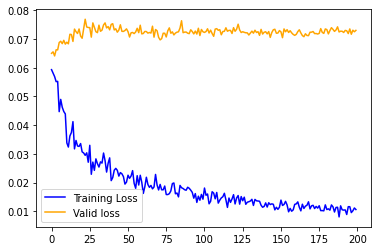

In [16]:
import matplotlib.pyplot as plt

print("Number of epochs:", len(data["epochs"]))
train_loss = [epoch["train_loss"] for epoch in data["epochs"]]
valid_loss = [epoch["valid_loss"] for epoch in data["epochs"]]
plt.plot(range(len(data["epochs"])), train_loss, color="blue", label="Training Loss")
plt.plot(range(len(data["epochs"])), valid_loss, color="orange", label="Valid loss")
plt.legend()
plt.show()

# Tests

In [7]:
from dataset_utils import inspect_events_bag

folder = r"G:\VM\Shared Folder\bags"
# for bag in os.listdir(folder):
    # bag_path = os.path.join(folder, bag)
    # inspect_events_bag(bag_path, bag + ".mp4", "/cam0/events", "/cam0/image_raw", 3)

In [12]:
bag_path = os.path.join(folder, "0001.bag")

import rosbag
with rosbag.Bag(bag_path) as b:
    types, topics = b.get_type_and_topic_info()
    print(topics)
    # for topic, msg, _ in b.read_messages():
    #     print(str(msg)[:500])
    #     data = msg.data
    #     break

{'/cam0/events': TopicTuple(msg_type='dvs_msgs/EventArray', message_count=1458, connections=1, frequency=323.7198256704356), '/cam0/image_raw': TopicTuple(msg_type='sensor_msgs/Image', message_count=141, connections=1, frequency=28.581411650212246)}


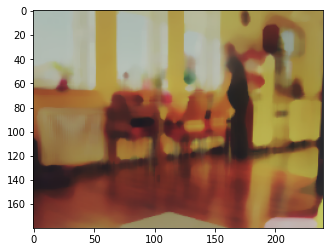

In [19]:
from media_utils import image_from_buffer, bgr_to_rgb
img = image_from_buffer(data, msg.width, msg.height, 3)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = bgr_to_rgb(img)
plt.imshow(img)

In [ ]:
from dataset_utils import inspect_events_batches
path = r"C:\datasets\CEDDataset\simple_color_keyboard_1\batches"
# path = r"C:\datasets\preprocess_800_0.5\0001\batches"
inspect_events_batches(path, "simple_color_keyboard_1.mp4", fps=10)

In [4]:
# from dataset_utils import convert_bag_to_bin
src = r"G:\CED Datasets\simple_color_keyboard_2.bag"
dst = r"G:\CED Datasets\simple_color_keyboard_2.bin"
# convert_bag_to_bin(src, dst, "/dvs/image_color")

In [12]:
from dataset_utils import dataset_generator_from_batches, dataset_generator_from_bag_n_events, inspect_events_generator
from dataset import DIV2KDataset
from media_utils import save_events_frames_visualization

# path = r"G:\VM\Shared Folder\bags\DIV2K_0.5\0001.bag"
# gen = dataset_generator_from_bag_n_events(path, 25_000, events_topic="/cam0/events", image_topic="/cam0/image_raw")

path = r"G:\CED Datasets\simple_wires_1.bag"
gen = dataset_generator_from_bag_n_events(path, 1_000, crop_size=(128, 128))
# print(next(iter(gen))[1].shape)
inspect_events_generator("#dataset.mp4", gen, fps=15)

# save_batches_to_disk(gen, r"G:\CED Datasets\simple_wires_1_new_batches")

ds = DIV2KDataset(r"G:\CED Datasets", sequences=["simple_wires_1_new_batches"])
# inspect_events_generator("#dataset.mp4", ds, fps=15)
# dl = torch.utils.data.DataLoader(ds, batch_size=24)
# save_events_frames_visualization((128, 128), "#predict.mp4", dl, model, fps=15)



width 128 height 128


 26%|██▌       | 73/281 [02:33<07:17,  2.10s/it]










































































































































































100%|██████████| 281/281 [01:07<00:00,  4.16it/s]
230it [01:03,  3.65it/s]


In [58]:
# gen = dataset_generator_from_batches(r"G:\CED Datasets\simple_wires_1_new_batches")
gen = ds
events, img = next(iter(gen))


(260, 346) (260, 346, 3)


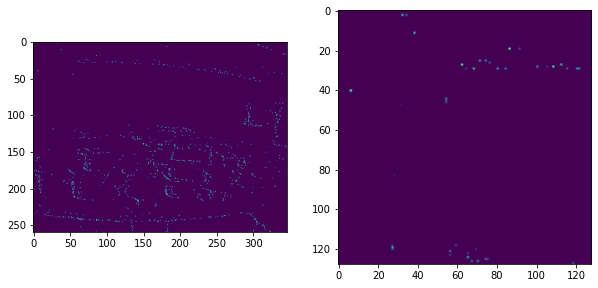

In [64]:
import matplotlib.pyplot as plt
print(events[0].shape, img.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(events[0])
plt.subplot(1, 2, 2)
plt.imshow(events[0][:128, :128])
plt.show()
